# Advection with wave limiters

In [177]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [178]:
import ipywidgets
from __future__ import print_function #for Python2

## True Solution

In [179]:
def qtrue(x,t,u):
    x0 = x - u*t   # trace back characteristic to time 0
    x0 = mod(x0, 1.)  # use periodic boundary conditions to map to [0,1]
    q = where(abs(x0-0.2) < 0.1,  3., 2.)   # piecewise constant with values 2 and 3
    return q

## Wave Limiters

In [180]:
def phi_minmod(theta):
    return(max(0.,min(theta,1)))

In [181]:
def wave_limiter(x,tfinal,nsteps,u,qtrue,nplot,phi, ylim1, ylim2):
    
    # set initial data:
    q0 = qtrue(x,0.,u)

    # plot initial data:
    fig = figure()
    xfine = linspace(0,1,5000)   # fine grid for plotting true solution
    plot(xfine, qtrue(xfine,0.,u),'r-')
    title('Initial data')
    plot(x,q0,'bo')
    ylim(ylim1, ylim2)

    # Start accumulating figures
    # Will add more figures during time stepping
    figs = [fig]  
    close(fig)  # so it won't appear yet


    # extend to include 2 ghost cells on each side:
    qn_ext = hstack([0., 0., q0, 0., 0.])
    i1 = 2  # index of first interior cell
    imx = mx+1  # index of last interior cell

    for n in range(nsteps):

        # fill ghost cells for periodic BCs:
        qn_ext[i1-2] = qn_ext[imx-1]
        qn_ext[i1-1] = qn_ext[imx]
        qn_ext[imx+1] = qn_ext[i1]
        qn_ext[imx+2] = qn_ext[i1+1]

        qnp_ext = qn_ext.copy()  # make a copy, not a new pointer to old array
        ucomp = 0.5*abs(u)*(1- abs(u)*dt/dx)

        for i in range(i1,imx+1):
            Wm= qn_ext[i]-qn_ext[i-1]
            Wp= qn_ext[i+1]-qn_ext[i]
            
            if u > 0:
                t1= qn_ext[i-1]-qn_ext[i-2]
                t2 =qn_ext[i]-qn_ext[i-1]
                if t2 ==0:
                    if t1==0:
                        thetam=0
                    else:
                        thetam =Inf
                else:
                    thetam= t1/t2
                t3=qn_ext[i]-qn_ext[i-1] 
                t4= qn_ext[i+1]-qn_ext[i]
                if t4 ==0:
                    if t3==0:
                        thetap=0
                    else:
                        thetap =Inf
                else:
                    thetap=t3/t4
                        
                     
                Ftildem = ucomp*(phi(thetam))*Wm
                Ftildep = ucomp*(phi(thetap))*Wp
                qnp_ext[i] = qn_ext[i] - udtdx*Wm-(dt/dx)*(Ftildep-Ftildem)
            else:
                t1= qn_ext[i+1]-qn_ext[i+2]
                t2 =qn_ext[i]-qn_ext[i-1]
                if t2 ==0:
                    if t1==0:
                        thetam=0
                    else:
                        thetam =Inf
                else:
                    thetam= t1/t2
                t3=qn_ext[i+2]-qn_ext[i+1] 
                t4= qn_ext[i+1]-qn_ext[i]
                if t4 ==0:
                    if t3==0:
                        thetap=0
                    else:
                        thetap =Inf
                else:
                    thetap=t3/t4
                        
                     
                Ftildem = ucomp*(phi(thetam))*Wm
                Ftildep = ucomp*(phi(thetap))*Wp
                qnp_ext[i] = qn_ext[i] - dtdx * (u*Wm)-dtdx*(Ftildep-Ftildem)

        qn_ext = qnp_ext

        if mod(n,nplot) == 0:
            fig = figure()
            qn = qn_ext[i1:imx+1]
            plot(x,qn,'bo-')
            ylim(ylim1, ylim2)
            tn = (n+1)*dt
            plot(xfine, qtrue(xfine,tn,u),'r-')
            title('Time t = %g' % tn)
            figs.append(fig)
            close(fig)

    print("Took %i time steps and produced %i figures" % (nsteps,len(figs)))
    return figs

In [182]:
xlower = 0.
xupper = 1.
mx = 50
dx = float(xupper-xlower)/mx

# finite volume cell centers:
x = linspace(xlower+0.5*dx, xupper-0.5*dx, mx)
u = 1.

tfinal = 2.0
nsteps = 150
dt = float(tfinal)/nsteps
udtdx = u*dt/dx
cfl = abs(udtdx)
print("dx = %6.4f, dt = %6.4f, Courant number is cfl = %5.2f" % (dx,dt,cfl))

# Run the upwind method, which returns the set of figures, 
# plotting every nplot steps:
nplot = 2
figs = wave_limiter(x,tfinal,nsteps,u,qtrue,nplot, phi_upwind, 1,4)

dx = 0.0200, dt = 0.0133, Courant number is cfl =  0.67
Took 150 time steps and produced 76 figures


## Results

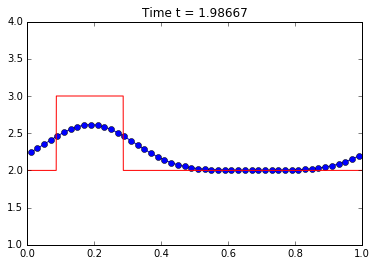

In [183]:
def display_frame(frameno): 
    display(figs[frameno])
    
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

## Limiter functions

In [184]:
def phi_superbee(theta):
    return(max(0.,min(2*theta,1),min(theta,2)))
def phi_MC(theta):
    return(max(0.,min(2*theta,(1+theta)/2,2)))
def phi_upwind(theta):
    return 0
def phi_LW(theta):
    return 1

## Fig 6.2

In [185]:
def qtrue1(x,t,u):
    x0 = x - u*t   # trace back characteristic to time 0
    x0 = mod(x0, 1.)  # use periodic boundary conditions to map to [0,1]
    q1 = where(abs(x0-0.7) < 0.1,  1., 0.)   
    q2 = exp(-200*(x0 - 0.3)**2)
    q=q1+q2
    return q

In [186]:
xlower = 0.
xupper = 1.
mx = 50
dx = float(xupper-xlower)/mx

# finite volume cell centers:
x = linspace(xlower+0.5*dx, xupper-0.5*dx, mx)
u = 1.

tfinal = 5.0
nsteps = 300
dt = float(tfinal)/nsteps
udtdx = u*dt/dx
cfl = abs(udtdx)
print("dx = %6.4f, dt = %6.4f, Courant number is cfl = %5.2f" % (dx,dt,cfl))

# Run the upwind method, which returns the set of figures, 
# plotting every nplot steps:
nplot = 5

dx = 0.0200, dt = 0.0167, Courant number is cfl =  0.83


minmod

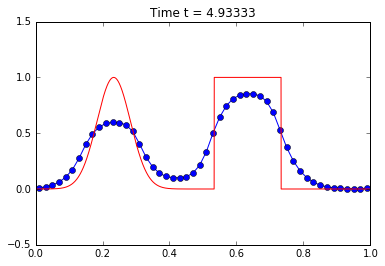

In [188]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue1,nplot, phi_minmod,-0.5,1.5)
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

MC

In [189]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue1,nplot, phi_MC,-0.5,1.5)

Took 300 time steps and produced 61 figures


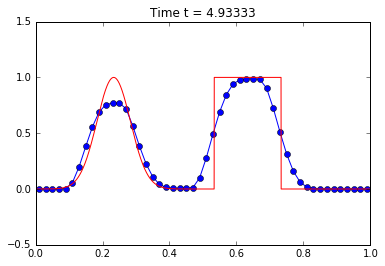

In [190]:
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

Superbee

In [191]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue1,nplot, phi_superbee,-0.5,1.5)

Took 300 time steps and produced 61 figures


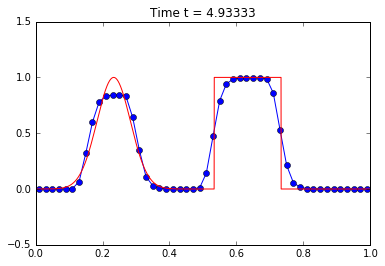

In [192]:
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

## Fig 6.3

In [193]:
def qtrue2(x,t,u):
    x0 = x - u*t   # trace back characteristic to time 0
    x0 = mod(x0, 1.)  # use periodic boundary conditions to map to [0,1]
    q=exp(-200*(x0 - 0.5)**2) * sin(80*x0)
    return q

In [194]:
xlower = 0.
xupper = 1.
mx = 50
dx = float(xupper-xlower)/mx

# finite volume cell centers:
x = linspace(xlower+0.5*dx, xupper-0.5*dx, mx)
u = 1.

tfinal = 10.0
nsteps = 600
dt = float(tfinal)/nsteps
udtdx = u*dt/dx
cfl = abs(udtdx)
print("dx = %6.4f, dt = %6.4f, Courant number is cfl = %5.2f" % (dx,dt,cfl))

# Run the upwind method, which returns the set of figures, 
# plotting every nplot steps:
nplot = 10

dx = 0.0200, dt = 0.0167, Courant number is cfl =  0.83


Upwind

In [195]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue2,nplot, phi_upwind,-1.0,1.5)

Took 600 time steps and produced 61 figures


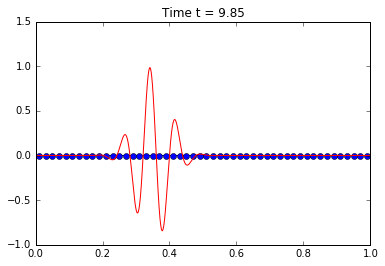

In [196]:
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

Lax-Wendroff

In [197]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue2,nplot, phi_LW,-1.0,1.5)

Took 600 time steps and produced 61 figures


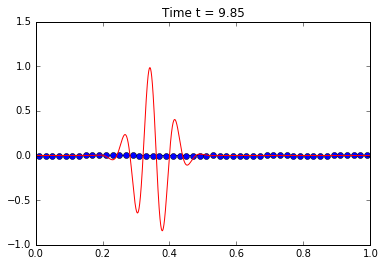

In [198]:
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

Superbee

In [199]:
figs = wave_limiter(x,tfinal,nsteps,u,qtrue2,nplot, phi_superbee,-1.0,1.5)

Took 600 time steps and produced 61 figures


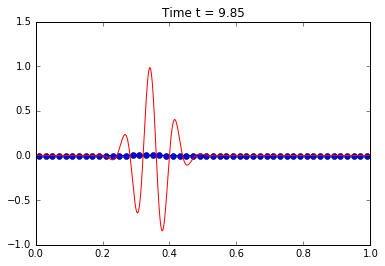

In [200]:
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)